### 0.0 IMPORTS


In [1]:
import pandas as pd
import inflection
import math
import random
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import xgboost as xgb

%matplotlib notebook
%matplotlib inline

from scipy                 import stats  as ss
from boruta                import BorutaPy
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.dummy         import DummyRegressor

import pickle
import seaborn as sns
from IPython.display import Image
import datetime
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

In [2]:
#setting default style for the graphs
sns.set_style("whitegrid")
#setting default text size
sns.set(font_scale=1.2)


In [3]:
df_sales_raw = pd.read_csv('train.csv')
df_store_raw = pd.read_csv('store.csv')

C:\Users\jcbre\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#merge databases
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

### 1 -  DATA DESCRIPTION

In [5]:
df1 = df_raw.copy() 

#### 1.1 RENAME COLUMNS

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
#renaming column names to all low cases separated by '_'
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

df1.columns = [inflection.underscore(x) for x in cols_old]

In [8]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

#### 1.2 DATA DIMENSIONS

In [9]:
print('Number of rows: {}'. format(df1.shape[0]))
print('Number of columns: {}'. format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


#### 1.3 DATA TYPES

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
#date it's as object type, must pass to date time
df1['date'] = pd.to_datetime(df1['date'])

#### 1.4 CHECK NA

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

#### 1.5 FILL OUT NA

DATA FIELDS DESCRIPTION

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [13]:
df1.competition_distance.max()

75860.0

In [14]:
#competition_distance
#NA here can be interpret as if the next competitor is to far way, so we can substitute the NA here for a
#value that is way above the max value, that will express this characteristic
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

#competition_open_since_month  
#let's assume that if there isn't date when the competition started, this date is at least the
#date of this report (if this isn't good, in feature eng. and model accuary terms, we can think
#more depply about this feature in the next CRISP cicle)
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if \
            math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     
#same logic as above
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if \
            math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week  
#same logic as above
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if \
            math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year               
#same logic as above
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year  if \
                math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval   
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug',\
             9:'Sep', 10:'Out', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

#dt.month will take only month from the date, and return the correspondent as a number.
#map using the dic month_map, will replace the correspondent number to the month abreviaton
df1['month_map'] = df1['date'].dt.month.map(month_map)

#here we map if the current date, month, of the row is in the 'promo_interval' schedule, being 1 if the 
#store is in promotion / with a added condition that 'promo_interval' if it is already 0 (cause wee 
#just set 0 for Na) maintain 0 (cause if you try to split(',') on a ZERO value, will give error)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 \
                else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [15]:
#now there is no NA
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

#### 1.6 CHANGE TYPES

Even though we've done this already, since that we applied some operations in the columns, it can change the types of out data

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

#### 1.7 STATISTICAL DESCRIPTION

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
#sepating categorical and numerical columns
num_attributes = df1.select_dtypes( include = ['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'] )

##### 1.7.1 NUMERICAL ATTRIBUTES

In [20]:
#central tendencys = mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#dispersion = std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T     
                  
#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'mediam', 'std', 'skew', 'kurtosis'])                  
                  

In [21]:
m

,attributes,min,max,range,mean,mediam,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


##### 1.7.2 CATEGORICAL  ATTRIBUTES

In [22]:
#getting the number of unique values of each categorical
cat_attributes.apply(lambda x: x.unique().shape[0])


state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

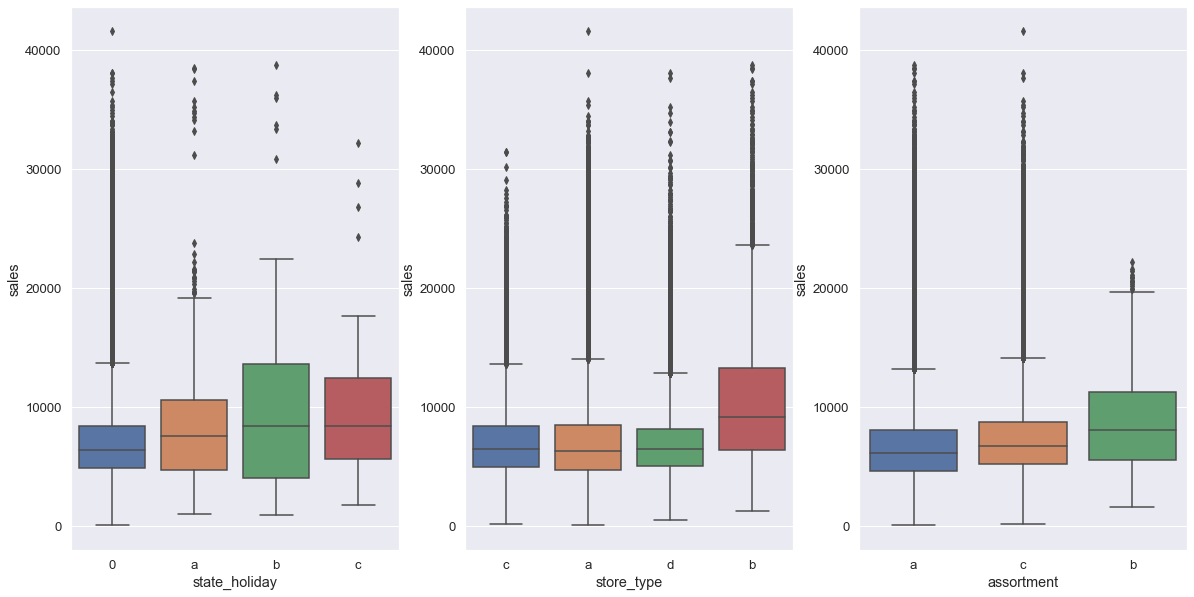

In [23]:
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]
plt.figure(figsize=(20, 10))

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux1 )

### 2 - FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

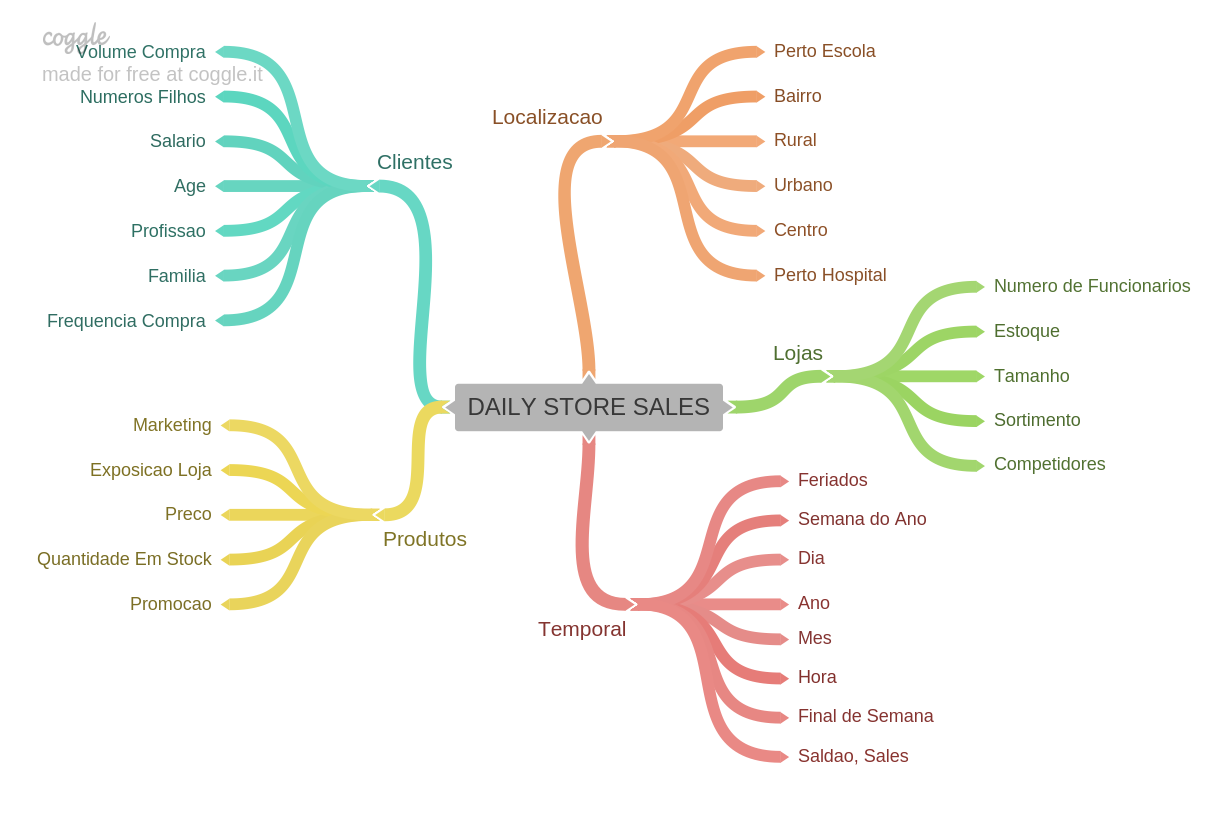

In [25]:
Image('img/MindMapHypothesis.png')

#### 2.1 HYPOTHESIS MIND MAP

##### 2.1.1. STORE HYPOTHESIS


1. Stores with a higher number of employees should sell more.

2. Stores with higher stock capacity should sell more.

3. Larger sized stores should sell more.

4. Stores with larger assortments should sell more.

5. Stores with closer competitors should sell less.

6. Stores with competitors for longer time period should sell more.

##### 2.1.2 PRODUCT  HYPOTHESIS

1. Stores that invest more in Marketing should sell more.

2. Stores with greater product exposure in shop windwons should sell more.

3. Stores with lower priced products should sell more.

5. Stores with more aggressive promotions (bigger discounts), should sell more.

6. Stores with active promotions for longer should sell more.

7. Stores with more promotion days should sell more.

8. Stores with more consecutive promotions should sell more.

##### 2.1.3 TIME  HYPOTHESIS

1. Stores open during the Christmas holiday should sell more.

2. Stores should sell more over the years.

3. Stores should sell more in the second half of the year.

4. Stores should sell more after the 10th of each month.

5. Stores should sell less on weekends.

6. Stores should sell less during school holidays.


#### 2.2 FINAL HYPOTHESIS LIST


In this cycle of CRISP, hypothesis that we can awnser with data that we already have it's prioritized.

Thus, are given preference for the folowing hypothesis:

1. Stores with a larger assortment should sell more.

2. Stores with closer competitors should sell less.

3. Stores with longer competitors should sell more.

4. Stores with active promotions for longer should sell more.

5. Stores with more days of promotion should sell more.

7. Stores with more consecutive promotions should sell more.

8. Stores open during the Christmas holiday should sell more.

9. Stores should sell more over the years.

10. Stores should sell more in the second half of the year.

11. Stores should sell more after the 10th of each month.

12. Stores should sell less on weekends.

13. Stores should sell less during school holidays.


#### 2.3 FEATURE ENGINEERING

In [26]:
#taking out the year, month and year to different variables
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since - since when the competetion has started
# this date is separated between two columns, need join
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                           month=x['competition_open_since_month'],day=1 ), axis=1)
#the amount of months since competition has started
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'] )/30).apply\
                            (lambda x: x.days ).astype(int)


# promo since - since when the promotion has started in the respective store
# geting this date in a string form
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
#getting the date from the string above
df2['promo_since'] = df2['promo_since'].apply\
            (lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))

In [27]:
#QUALITY CONTROL
#df2

In [28]:
#getting number of weeks since promotion started in the respective store
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days ).astype(int)

#assortment - setting categorical accordingly
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' \
                                            else 'extra' if x == 'b' else 'extended')
#state holiday - setting categorical accordingly
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' \
                    else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

### 3 - VARIABLES FILTERING

In [29]:
df3 = df2.copy()

#### 3.1 ROWS FILTERING

In [30]:
#since that a closed store don't offer any valueable data, 'open' = 0 should be filtered (cause a closed 
#stored do not sell, obviously, thus this variable condition do not provide any insight on sales, that is 
#target here). 
#same with sales. sales = 0 means this is a closed stored, thus not beeing a insightfull condition to our
#goal here
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

#for the next CRISP cicle, take out this condition for sales. If a store is open, and sales is 0, there 
#could be a trend to map of why this store didn't sale (or it's impossible for a open store not sell
#anything)

#### 3.1 COLUMNS SELECTION

In [31]:
#'customers' it's being dropped cause this isn't a value that we have projected for next 5 weeks (unless
#we create another model to predict this variable, and feed this model that we are building)
# since that 'open' was filtered, that is only ones on it, thus it is not relevant.
# 'promo_interval'and 'month_map' was support variables
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

### 4 - EXPLORATORY DATA  ANALYSIS

In [32]:
df4 = df3.copy()

#### 4.1 UNIVARIATE ANALYSIS

##### 4.1.1 RESPONSE VARIABLE

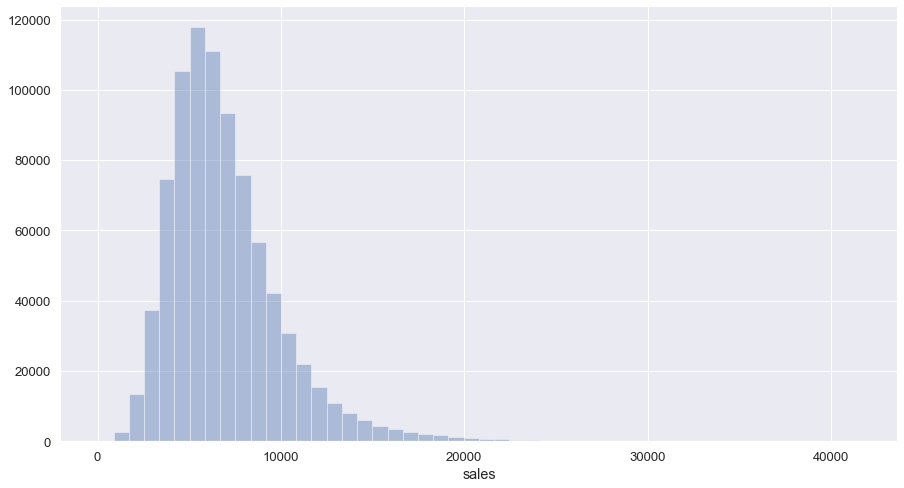

In [33]:
plt.figure(figsize=(15, 8))
sns.distplot(df4['sales'], kde=False )


##### 4.1.1 NUMERICAL VARIABLES

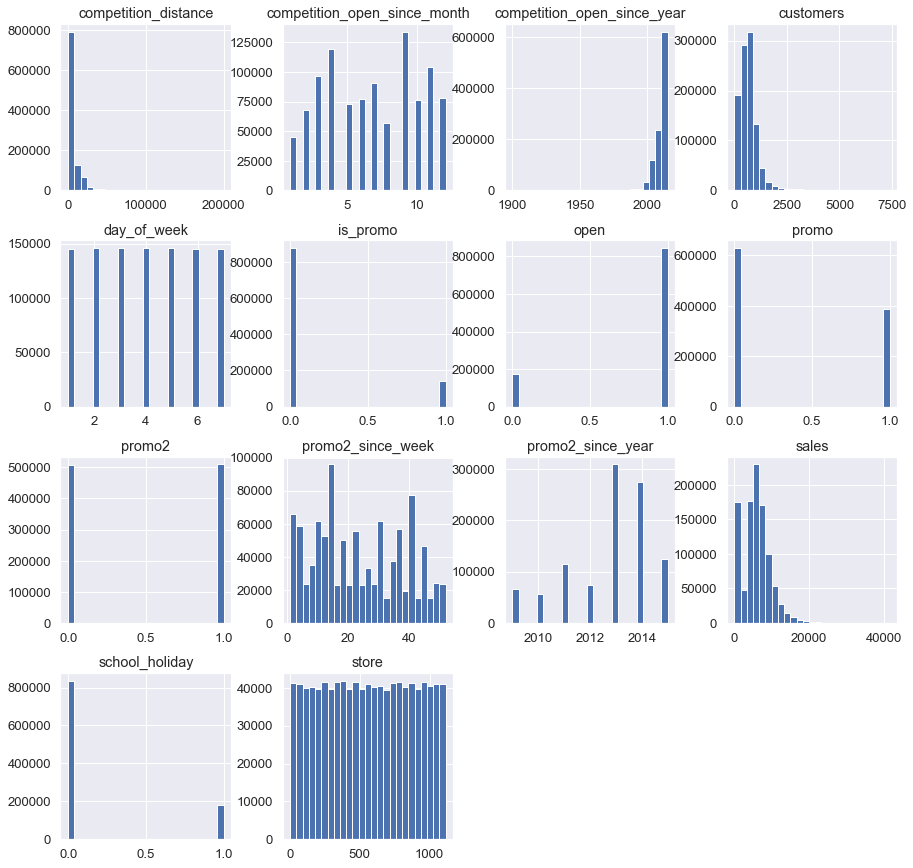

In [34]:
num_attributes.hist(figsize=(15, 15), bins=25);

##### 4.1.3 CATEGORICAL VARIABLES

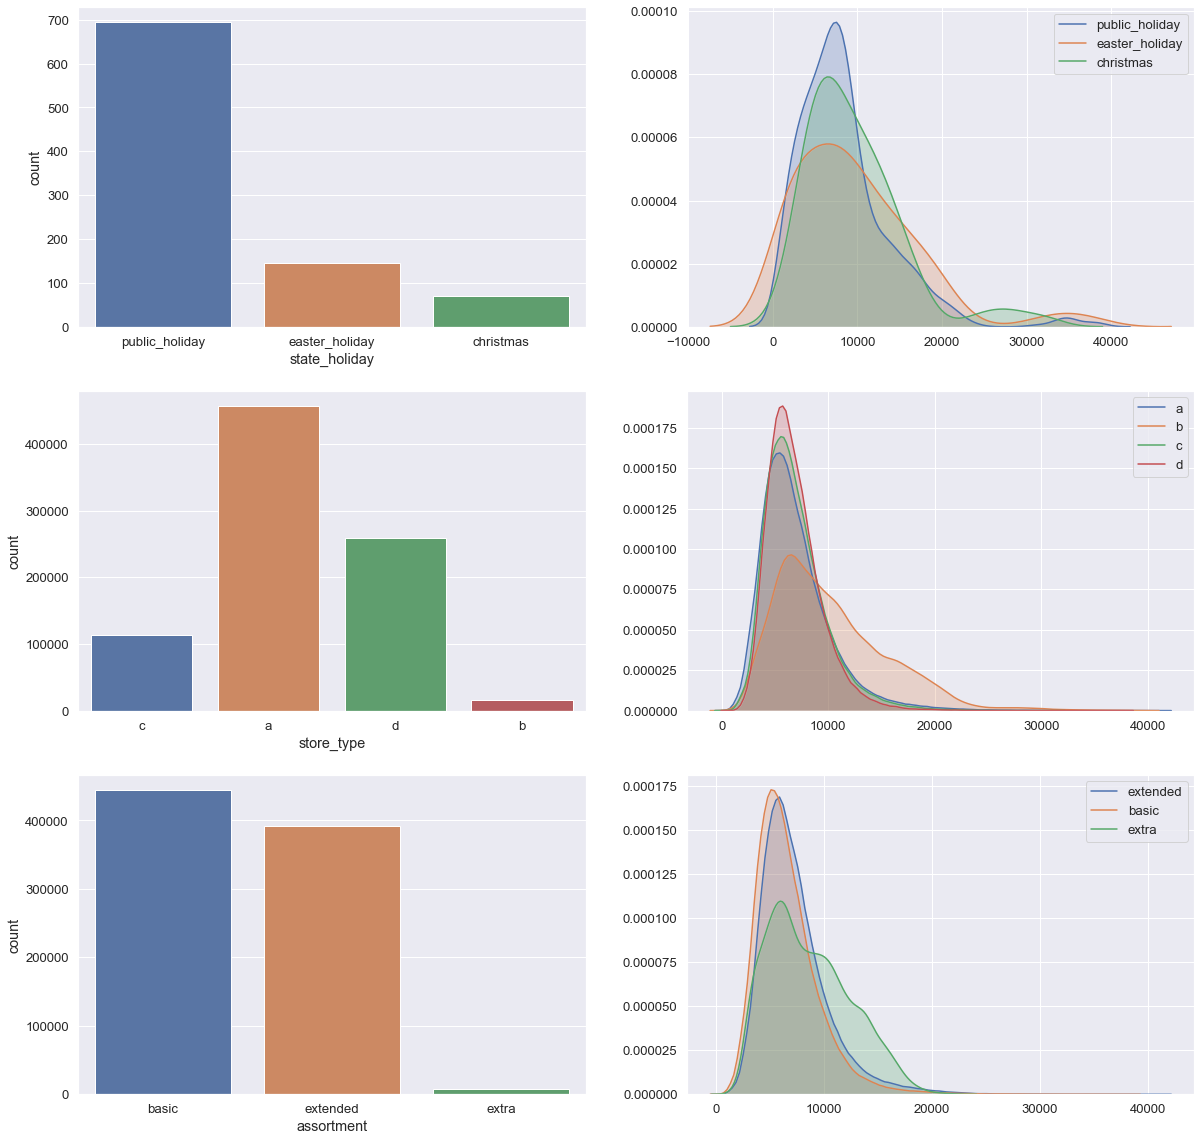

In [35]:
# state_holiday

plt.figure(figsize=(20, 20))
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

#### 4.2 BIVARIATE ANALYSIS

##### HYPOTHESIS VALIDATION

##### 1. Stores with a larger assortment should sell more.

**FALSE!** Stores with larger assortment sell less, as shown bellow

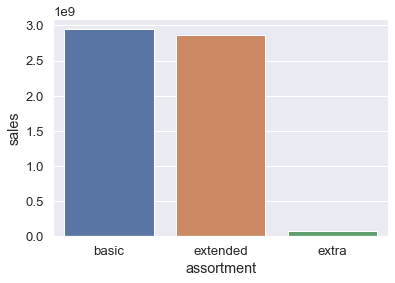

In [36]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

But can sales varied through time ? Can extra assortment sales began good and depreciated or the oposite?

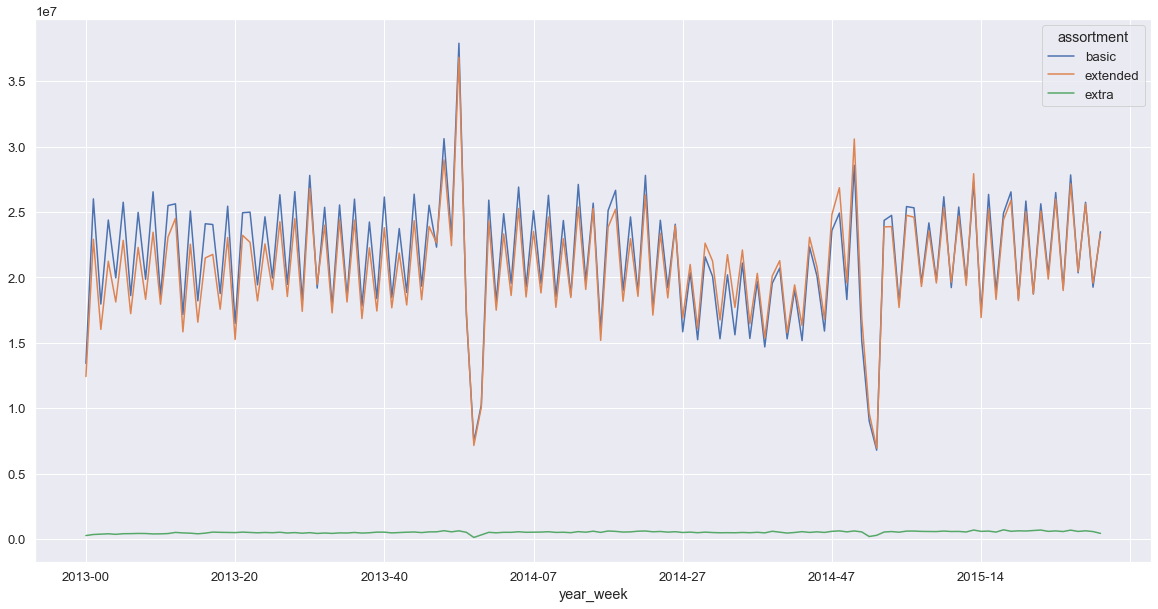

In [37]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot(figsize=(20, 10));


Since the scale of assortments types is very diferent, would be good to analyze assortment "extra" alone
to see it's behavior 

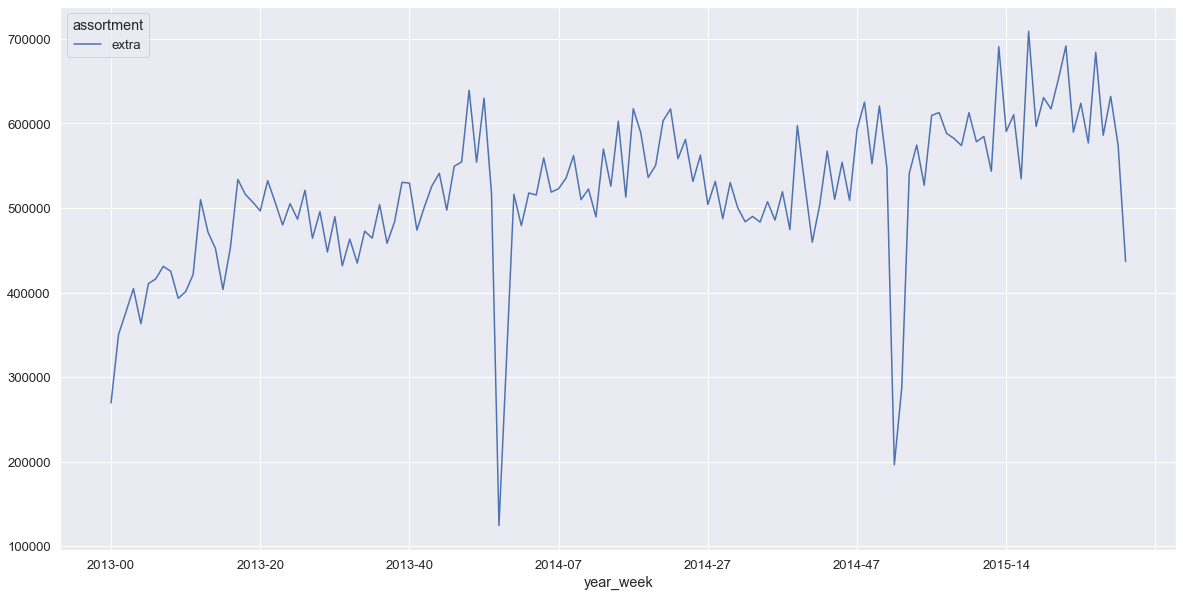

In [38]:
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot(figsize=(20, 10));

Assortment beharior show some variation and seasonality, but not important.

**Assortment is a important feature**. It is a feature that impact the target Sales

##### 2. Stores with closer competitors should sell less.

**FALSE**. Stores with close competitors sell **MORE**.

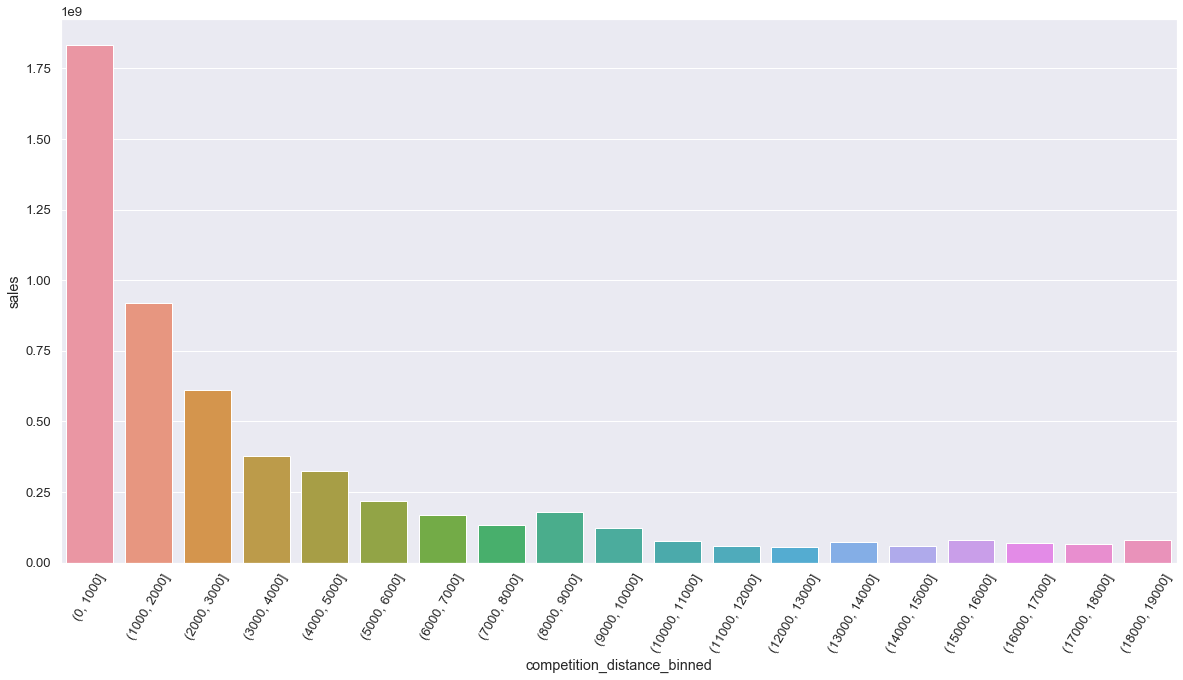

In [39]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
#since competition_distance is a continous value, would be nice to set it in bins to diplay it's values
#in groups in a barplot
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()

plt.figure(figsize=(20, 10))
sns.barplot( x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=60);


As shown above, stores with close competitors at most 1km distance sell double as much as stores with more than 1km of distante.

But is this feature important ?


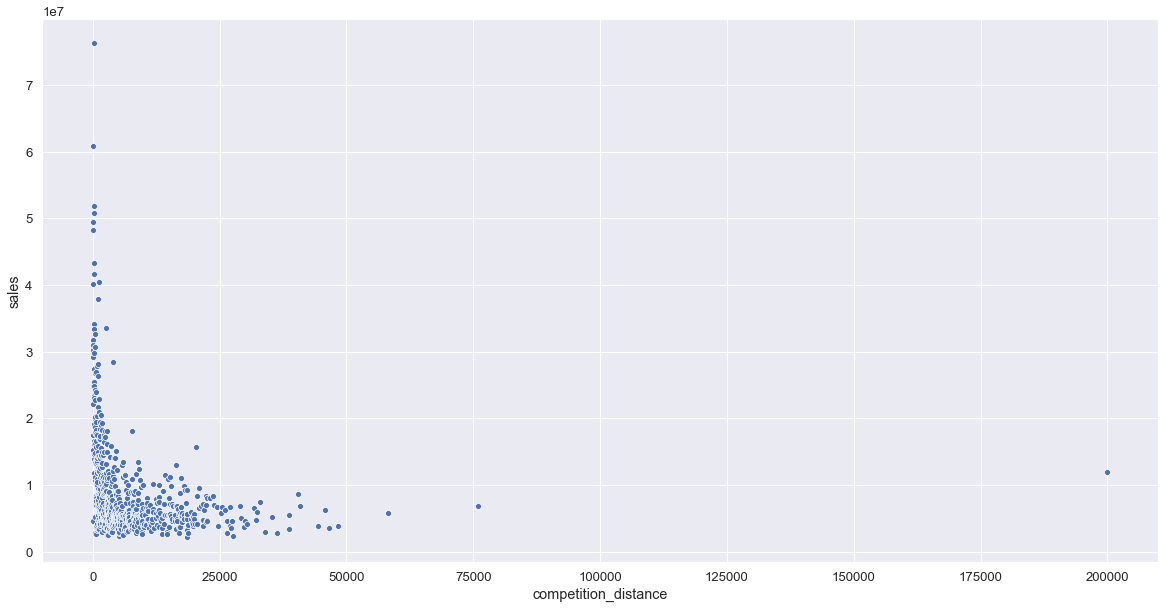

In [40]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x ='competition_distance', y='sales', data=aux1);

In [41]:
aux1.corr(method='pearson')

,competition_distance,sales
competition_distance,1.000000,-0.229415
sales,-0.229415,1.000000


The scatterplot graph show a concentration of high sales on stores with close competitors.

Although the person correlation it's somewhat weak, this feature should be considered on the model because it shows influence in sales. 

##### 3. Stores with  competitors for longer periods of time should sell more.

**FALSE**. Stores with recent competitors sell **MORE**.

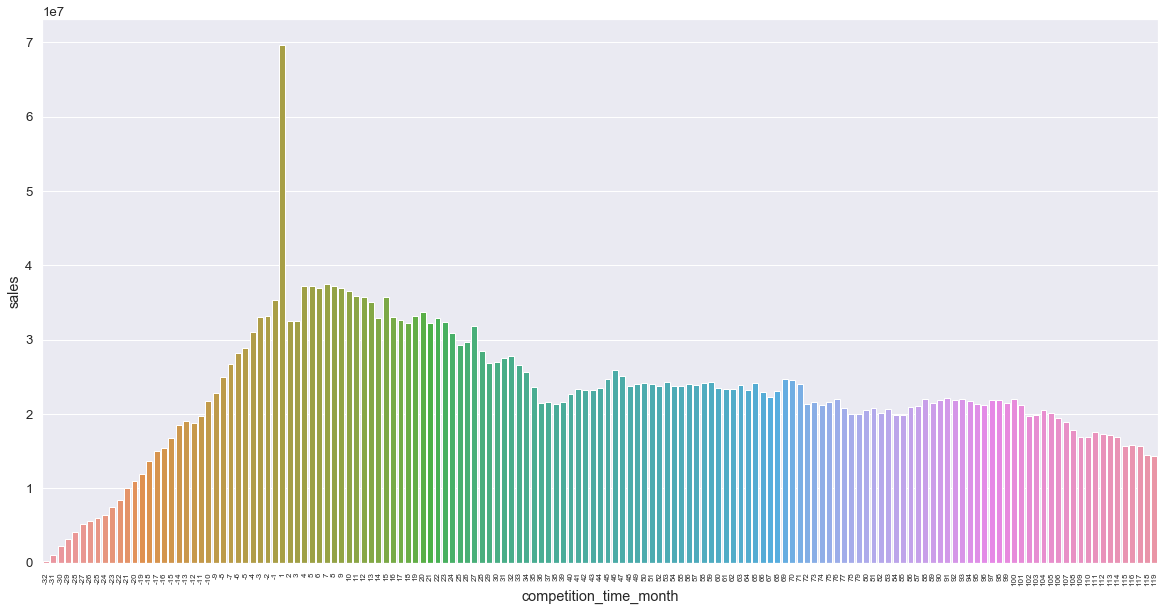

In [42]:
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]

fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
ax.tick_params(axis='x',  labelsize=8)
plt.xticks( rotation=90 );

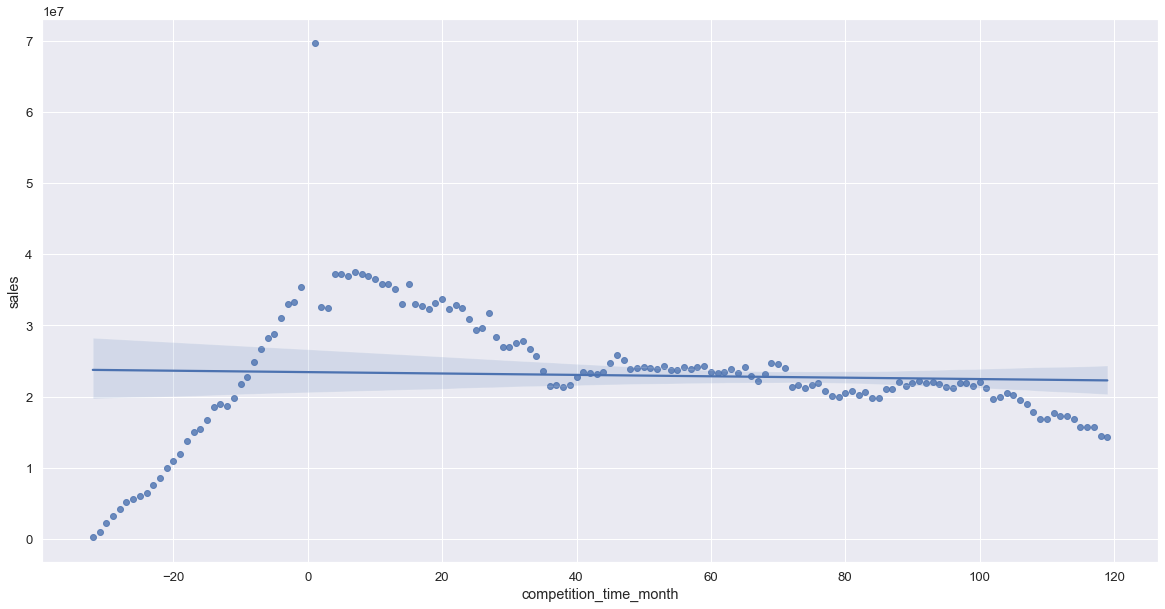

In [43]:
plt.subplots(figsize=(20, 10))
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

In [44]:
aux1.corr(method='pearson')

,competition_time_month,sales
competition_time_month,1.00000,-0.10142
sales,-0.10142,1.00000


The scatter plot above show a light correlation, as the pearson corr confirmns.

Although there is a light correlation, this feature gives can give hints to the model, thus this a feature to be considered.

##### 4. Stores with active promotions for longer should sell more.

**DEBATABLE**. Stores with long periods of active promotions sell less after some time of active promotions.

In the 'Extended promo' bar graph bellow, sales hold a baseline through some time before it go down. This baseline hold can be interpret as effect of the active promotion.

In the 'Regular promo" bar graph, we see the that sales start going up as get close to the start of the active promotion.


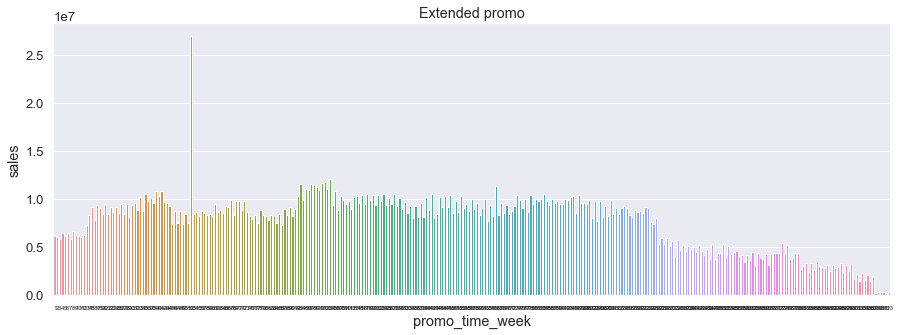

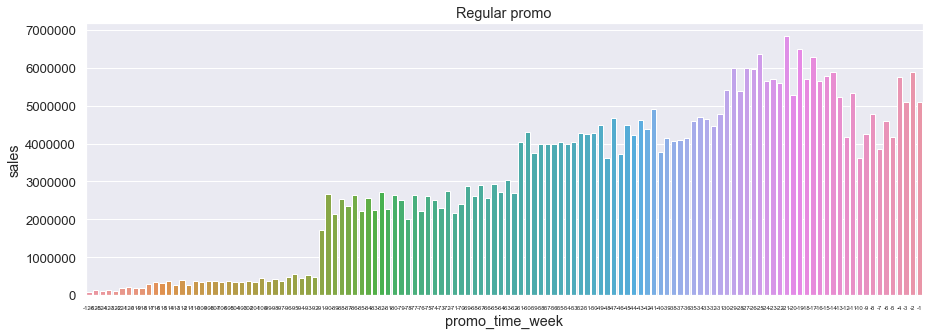

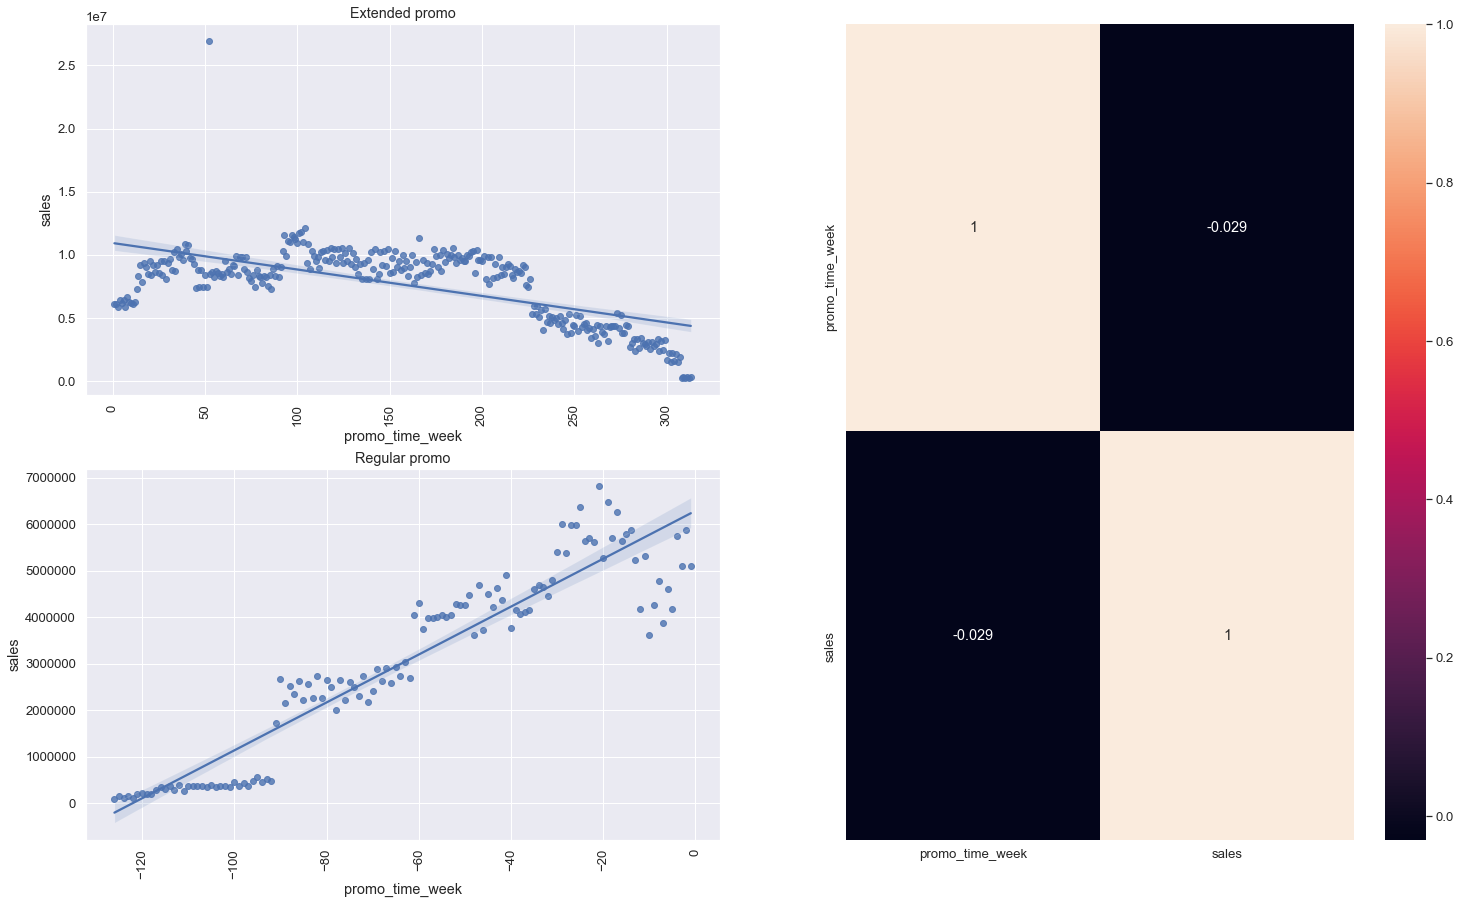

In [45]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot( x='promo_time_week', y='sales', data=aux2 ).set_title('Extended promo');
ax.tick_params(axis='x',  labelsize=6)

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot( x='promo_time_week', y='sales', data=aux3 ).set_title('Regular promo');
ax.tick_params(axis='x',  labelsize=6)

plt.figure(figsize=(25, 15))
grid = gridspec.GridSpec( 2, 2 )

plt.subplot( grid[0,0] )
sns.regplot( x='promo_time_week', y='sales', data=aux2).set_title('Extended promo') ;
plt.xticks( rotation=90 );

plt.subplot( grid[1,0] )
sns.regplot( x='promo_time_week', y='sales', data=aux3).set_title('Regular promo');
plt.xticks( rotation=90 );

plt.subplot( grid[:,1] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

Although that 'promo_time_week' have some correlation with sales, it's a very week correlations.

Pearson corr is very weak. This behavior can be seen in the baseline holded for to long in "Extend promo".

Unless this feature show stronger influene on sales combined with other feature, this is not a important feature.

##### <s> 5. Stores with more days of promotion should sell more.
    
To validate this hiphotesis new variables must be calculated. To do in the next CRISP cicle.

But we can infere the same conclusions as the hiphotesis 4 above, as the days of promotion should follow weeks of promotion tendency.

##### 7. Stores with more consecutive promotions should sell more.

**FALSE**. Stores with more consecutives promotions sell **LESS**.


In [46]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


Text(0, 0.5, 'Sales')

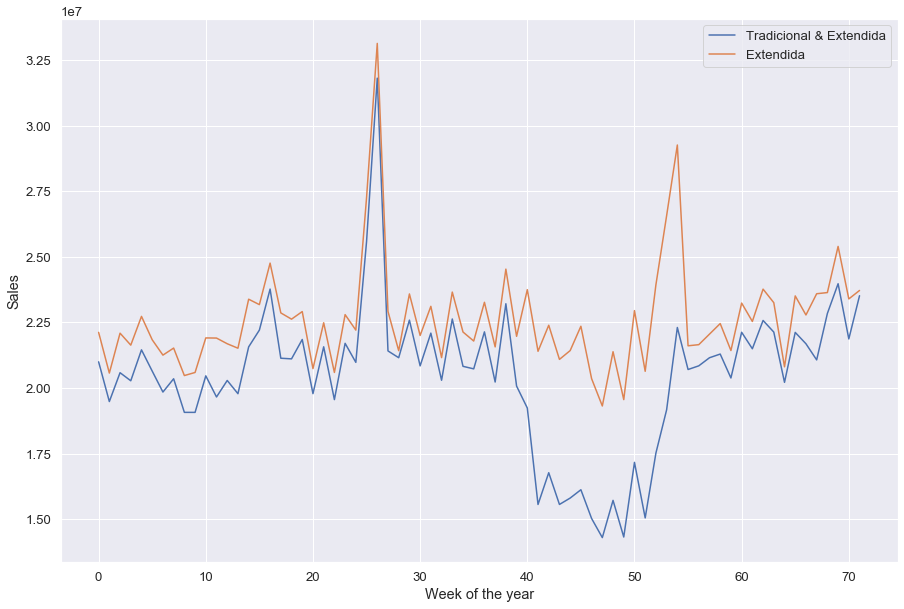

In [47]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot(figsize=(15, 10))

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);
plt.xlabel('Week of the year')
plt.ylabel('Sales')


Above we see that the behaviour of extended promotions (blue line) follow almost exactly the behaviour of normal promotions (orange line), but in a slightly lower baseline. Thus, it shows that extended promotions isn't a feature to be considered.

We have an outlier behaviour between weeks of the year 40 - 50, but this doesn't change our conclusion on this feature.



##### 8. Stores open during the Christmas holiday should sell more.

**FALSE**. Stores sell **LESS** on the christimas holliday.


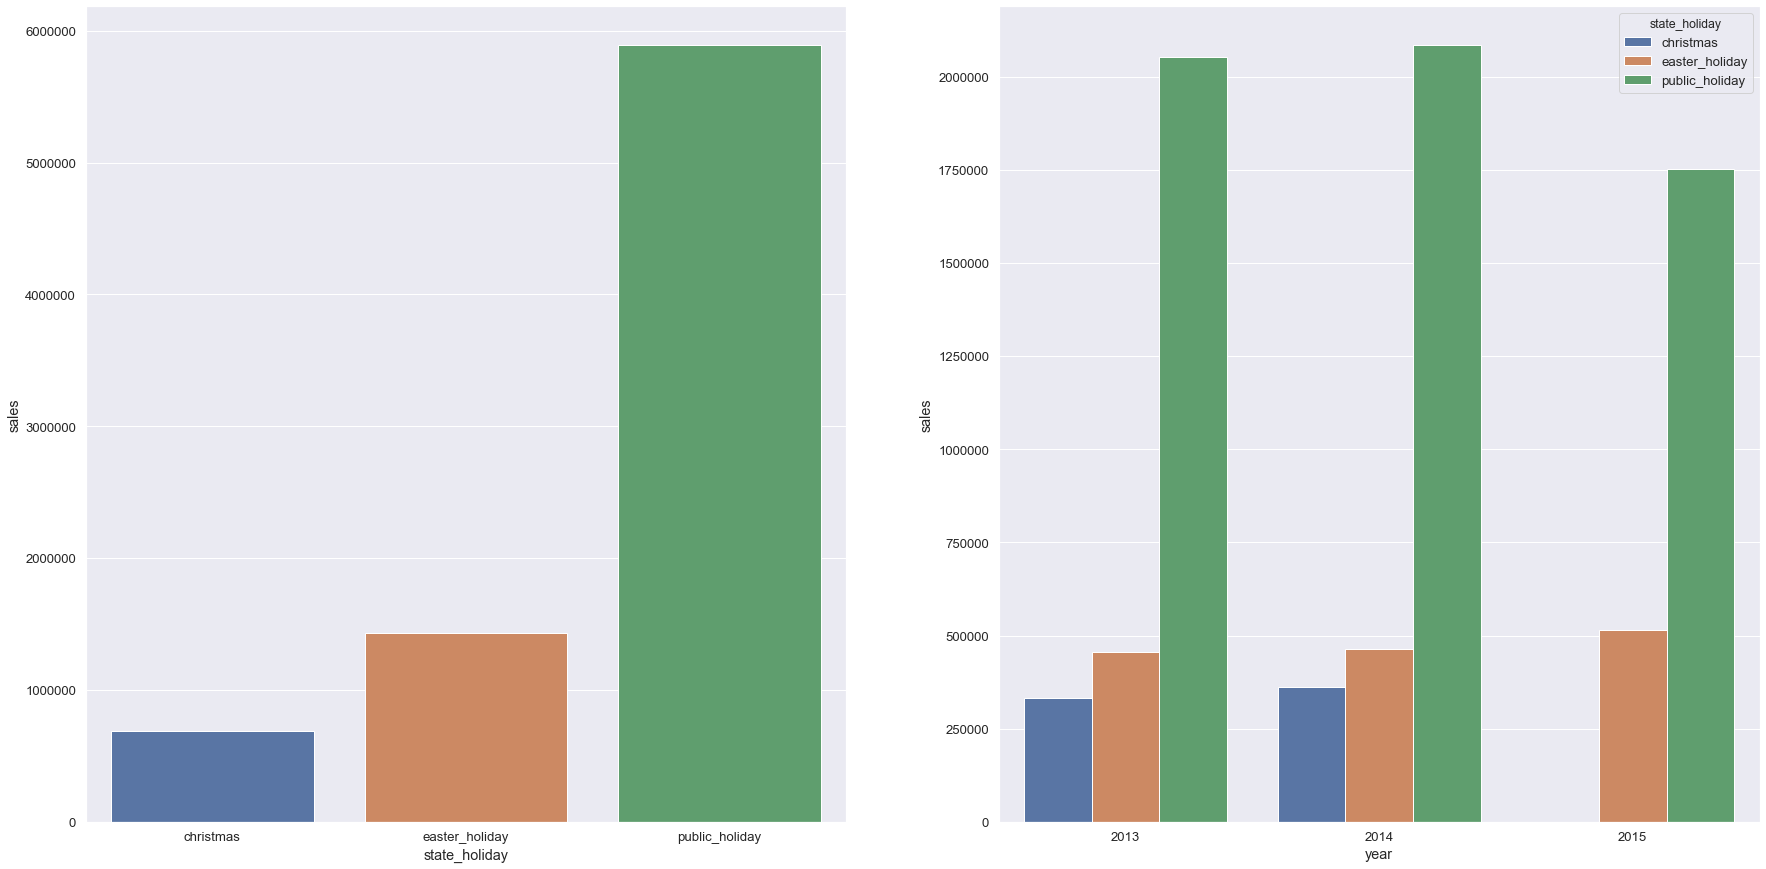

In [48]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplots(figsize=(30, 15))
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

##### 9. Stores should sell more over the years.

**FALSE**. Stores sell **LESS** over the years.


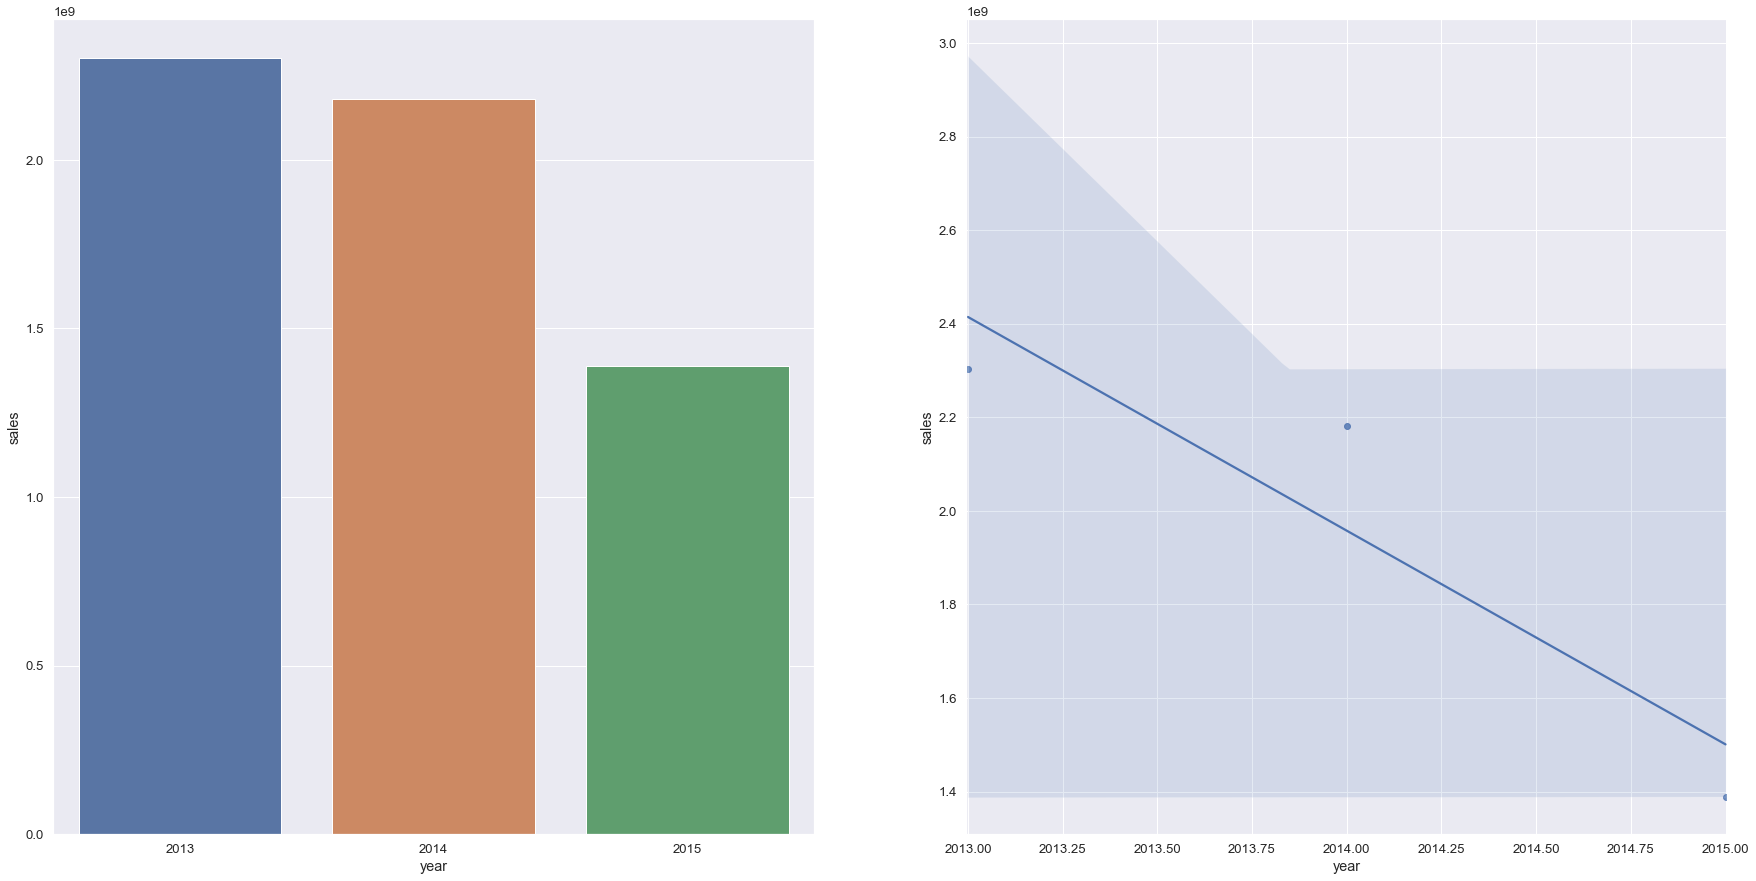

In [49]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplots(figsize=(30, 15))
plt.subplot( 1, 2, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

In [50]:
aux1.corr( method='pearson')

,year,sales
year,1.000000,-0.920984
sales,-0.920984,1.000000


We notice here a strong negative correlation, but it's strengh it's influenced by 2015 isn't closed.
Let's see how less strong it's this correlations without 2015

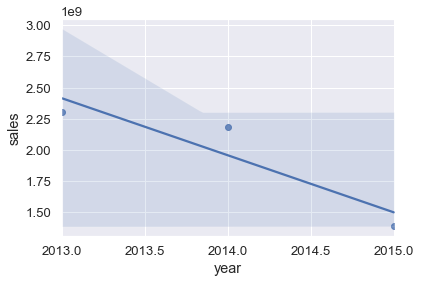

In [51]:
aux2 = df4[df4['year'] != 2015]
aux3 = aux2[['year', 'sales']].groupby( 'year' ).sum().reset_index()
sns.regplot( x='year', y='sales', data=aux1 );

In [52]:
aux3.corr( method='pearson')

,year,sales
year,1.0,-1.0
sales,-1.0,1.0


There is a even stronger negative relation without considering the unclosed year of 2015.

This a strong feature, must be considered in the model.

#####  10. Stores should sell more in the second half of the year.

**FALSE**. Stores sell **LESS** in the second semester.


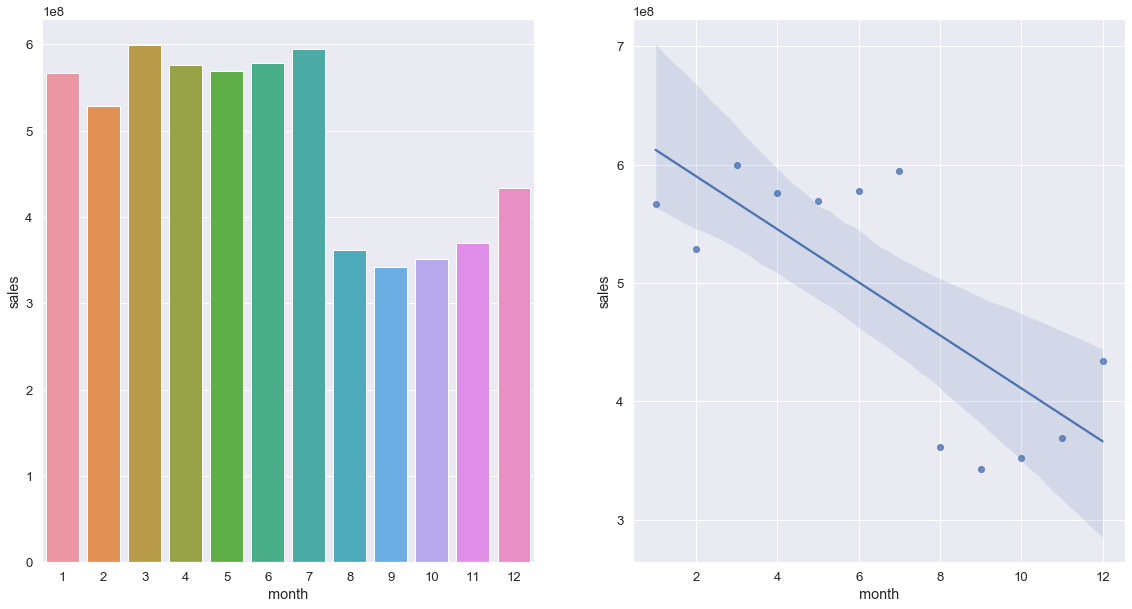

In [53]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplots(figsize=(30, 10))
plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

In [54]:
aux1.corr( method='pearson')

,month,sales
month,1.000000,-0.751711
sales,-0.751711,1.000000


This is another import feature to be considered in the model. There is a strong negative correlation between month and sales.

##### 11. Stores should sell more after the 10th of each month.

**FALSE**. Stores sell **LESS**  after the day 10th by day **ON AVARAGE**.


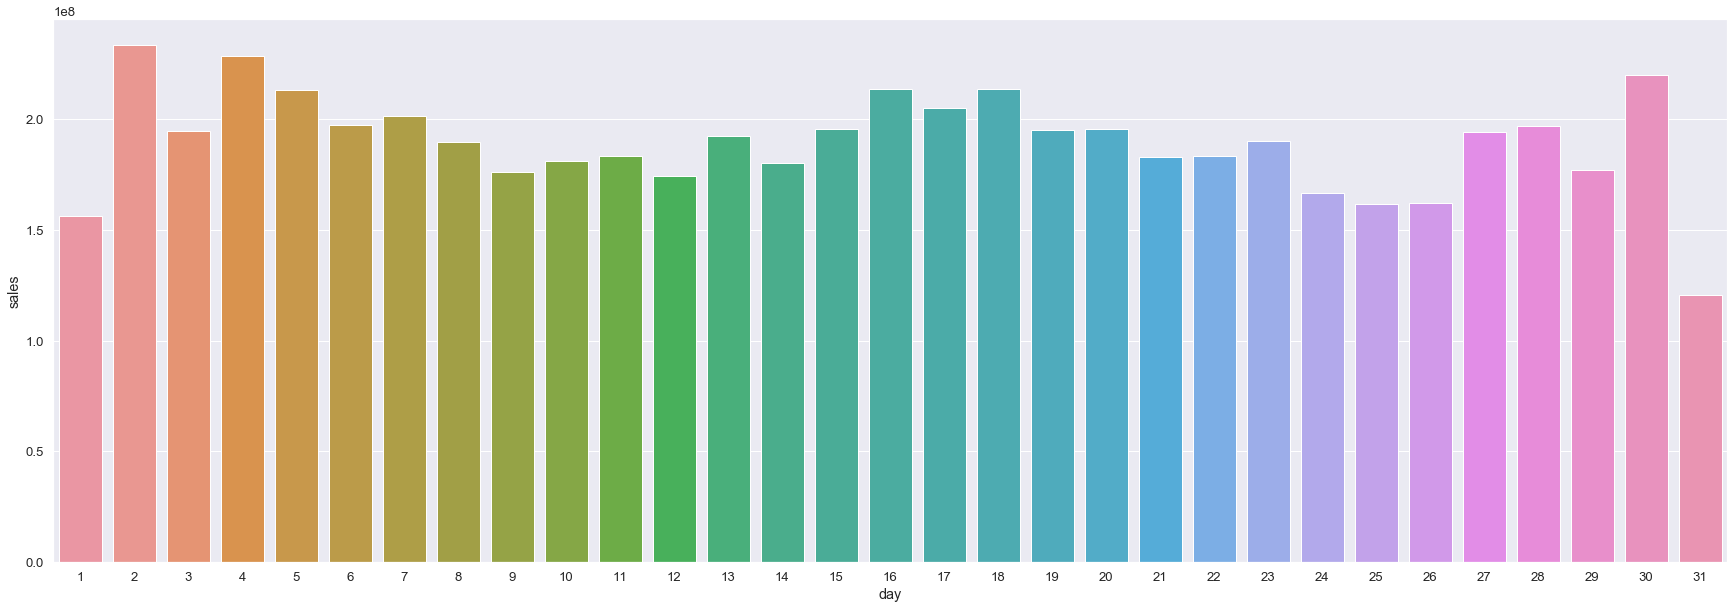

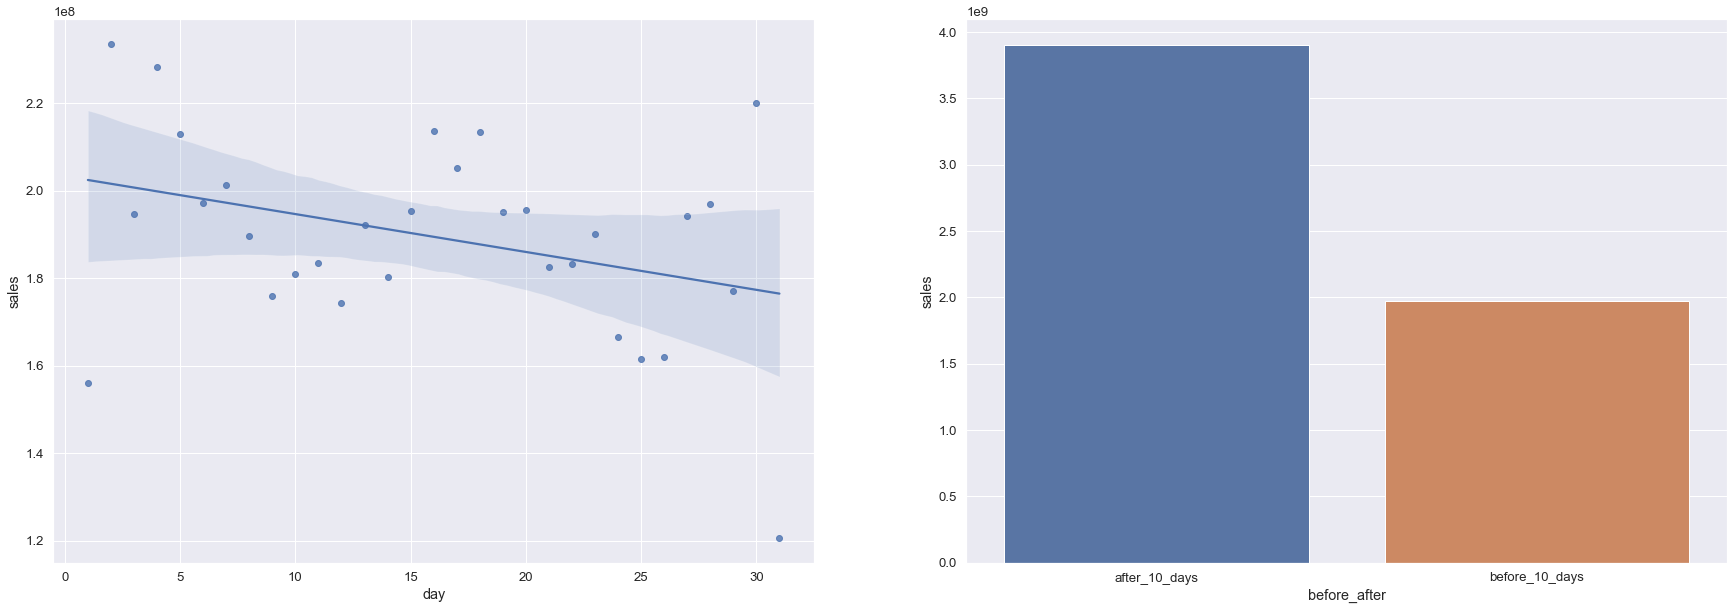

In [55]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.figure(figsize=(30, 10))
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplots(figsize=(30, 10))
plt.subplot( 1, 2, 1)
sns.regplot( x='day', y='sales', data=aux1 );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 1, 2, 2 )
sns.barplot( x='before_after', y='sales', data=aux2 );

In [56]:
aux1.corr( method='pearson' )

,day,sales
day,1.00000,-0.34602
sales,-0.34602,1.00000


Although the first third of the month sell less than the last 2/3 of the month, The last 2/3 of the month sell less by day, on avarage. Behaviour noticed by begative pearson correlation.

Let's confirm on data:

C:\Users\jcbre\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


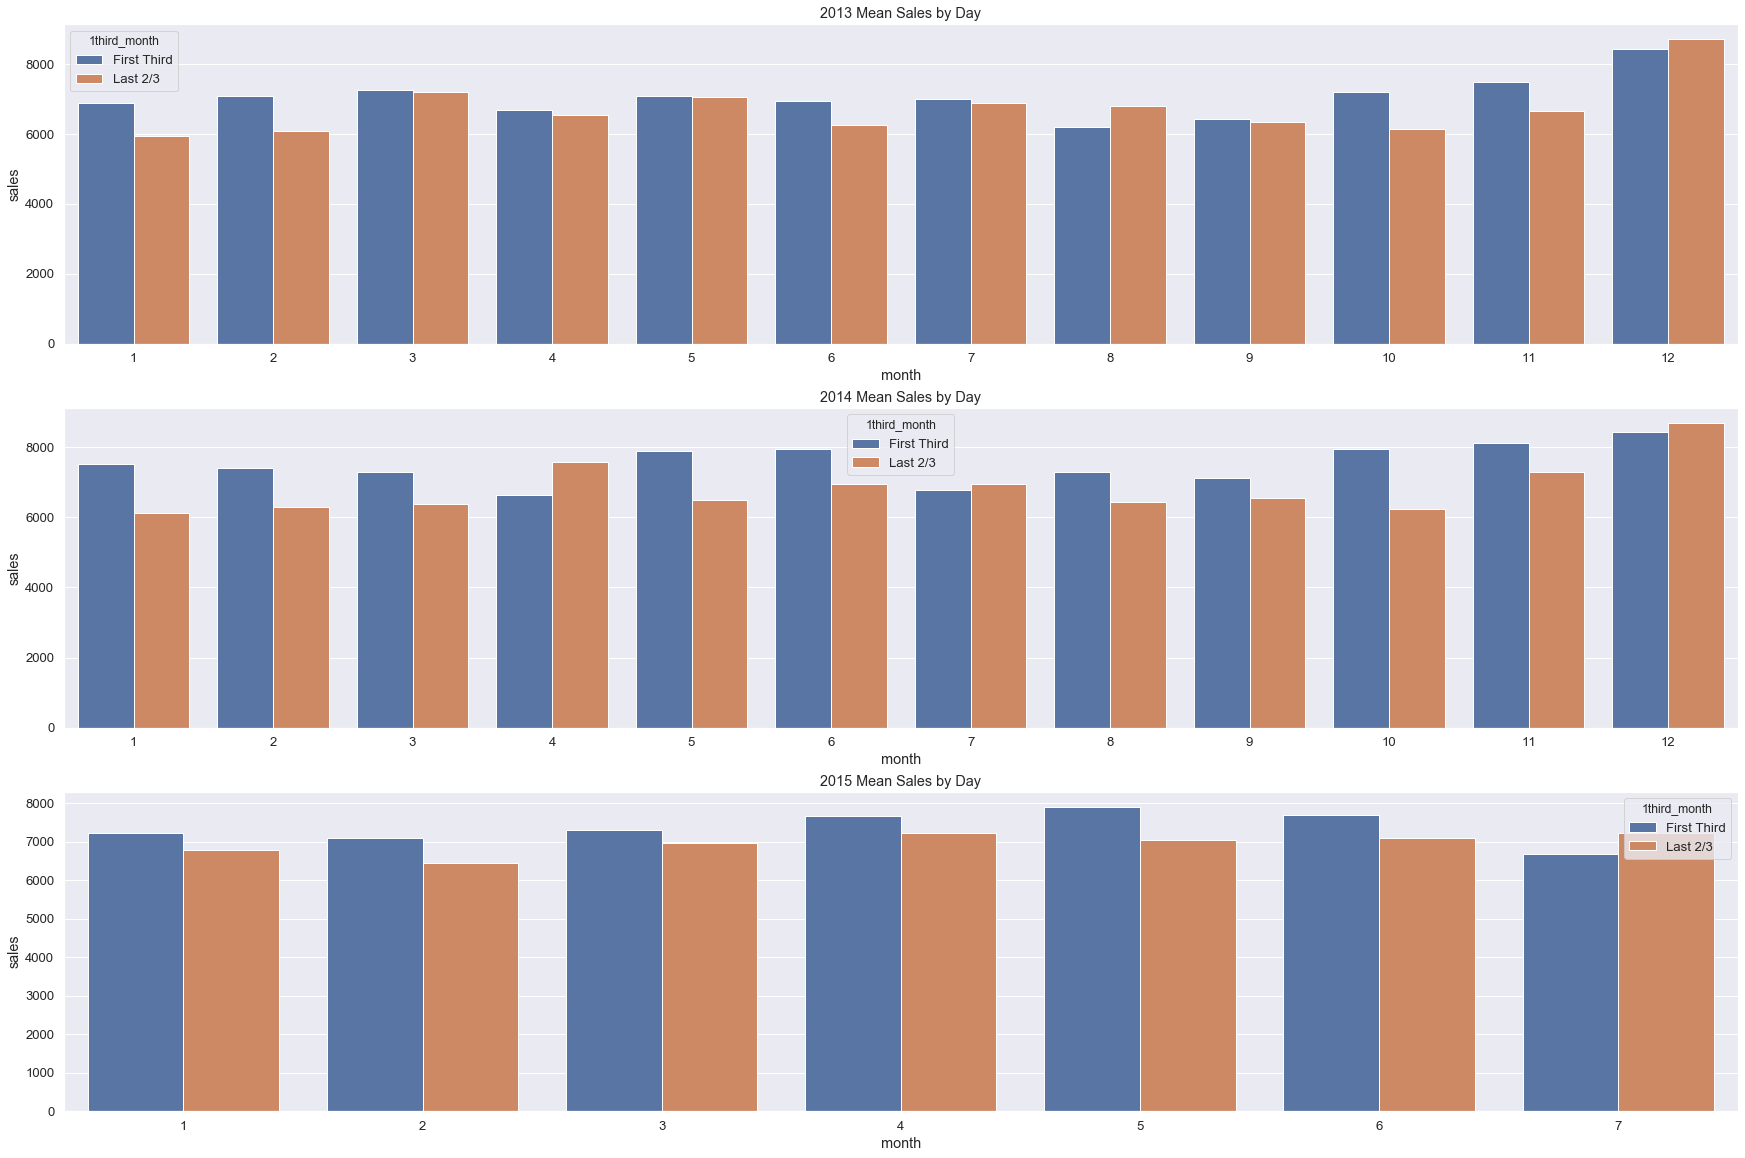

In [57]:
auxX = df4[['year', 'month', 'day', 'sales']]

auxX['1third_month'] = auxX['day'].apply( lambda x: 'First Third' if x <= 10 else 'Last 2/3' );

auxX2 = auxX.groupby(['year', 'month', '1third_month']).mean().reset_index();

plt.subplots(figsize=(30, 20));
plt.subplot(3,1,1)
sns.barplot( x='month', y='sales', hue = '1third_month', data=auxX2[auxX2['year'] == 2013]).\
                    set_title('2013 Mean Sales by Day' );
plt.subplot(3,1,2)
sns.barplot( x='month', y='sales', hue = '1third_month', data=auxX2[auxX2['year'] == 2014]).\
                    set_title('2014 Mean Sales by Day' );
plt.subplot(3,1,3)
sns.barplot( x='month', y='sales', hue = '1third_month', data=auxX2[auxX2['year'] == 2015]).\
                    set_title('2015 Mean Sales by Day' );


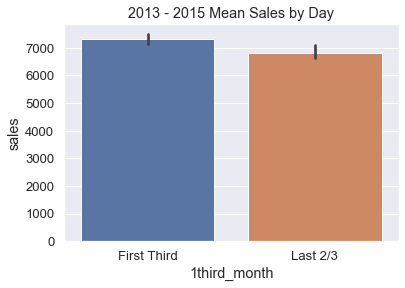

In [58]:
sns.barplot( x='1third_month', y='sales', data=auxX2).set_title('2013 - 2015 Mean Sales by Day');

We see that the first third of the month sell more by day on avarage. 

We see that trend throughout 2013 to 2015, with some outliers in between. But the graph '2013 - 2015 Mean Sales by Day' confirmn the trend.

Although weak, there is some considerable pearson correlation. And with the perceived trend noticed in the graphs, this is a important feature.


##### 12. Stores should sell less on weekends.

**TRUE**. Stores sell **LESS**  on weekends.


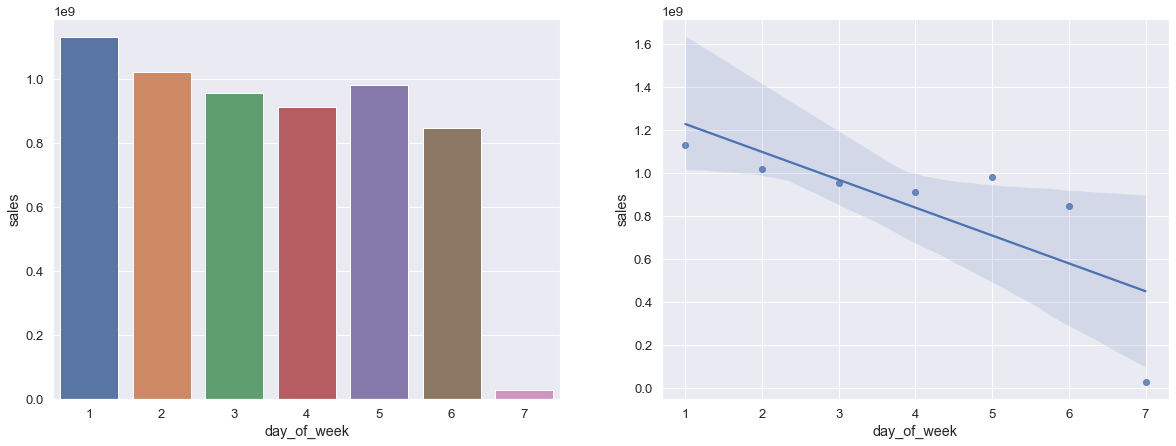

In [59]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplots(figsize=(20, 7))
plt.subplot( 1, 2, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

In [60]:
aux1.corr(method='pearson')

,day_of_week,sales
day_of_week,1.000000,-0.760303
sales,-0.760303,1.000000


There is a strong negative relation with this feature and sales. This is a important feature to the model.

##### 13. Stores should sell less during school holidays.

**TRUE**. Stores sell **LESS** during chool holidays, except for July and August.

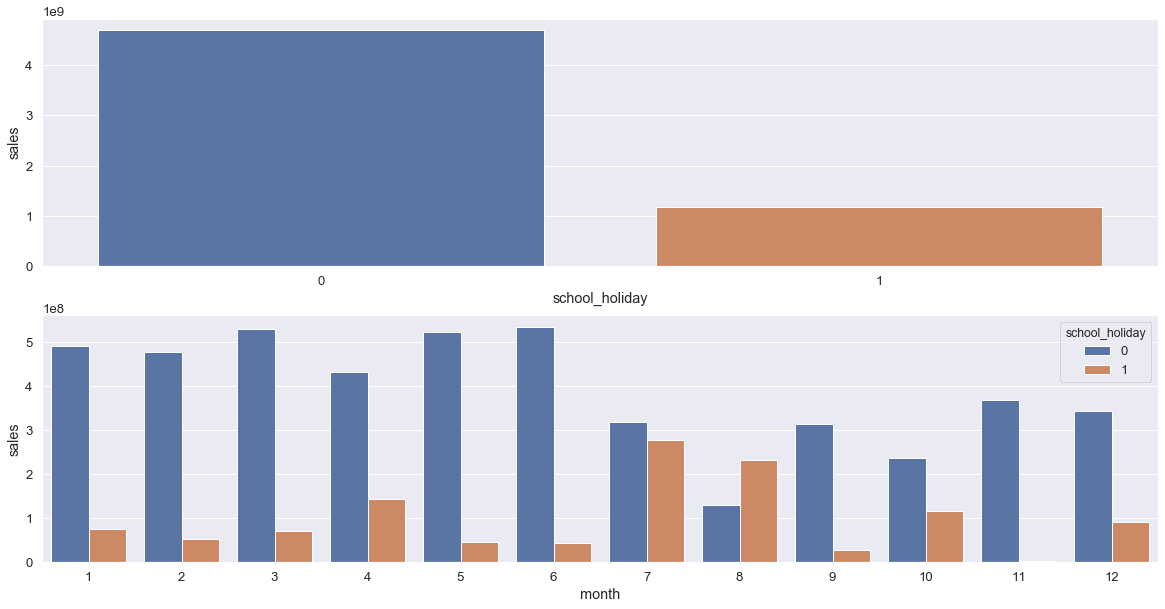

In [61]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplots(figsize=(20, 10))
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

In [62]:
aux1.corr( method='pearson' )

,school_holiday,sales
school_holiday,1.0,-1.0
sales,-1.0,1.0


In [63]:
aux1.corr( method='pearson' )

,school_holiday,sales
school_holiday,1.0,-1.0
sales,-1.0,1.0


##### HIPOSTHESIS RESUME

In [64]:
tab =[['Hiphotesis', 'Conclusion', 'Relevance'],
      ['H1', 'False', 'low'],  
      ['H2', 'False', 'avarage'],  
      ['H3', 'False', 'avarage'],
      ['H4', 'Debatable', 'low'],
      ['H5', '-', '-'],
      ['H7', 'False', 'low'],
      ['H8', 'False', 'avarage'],
      ['H9', 'False', 'High'],
      ['H10', 'False', 'High'],
      ['H11', 'False', 'avarage'],
      ['H12', 'True', 'High'],
      ['H13', 'True', 'low'],
     ]  

#from tabulate import tabulate
#print( tabulate( tab, headers='firstrow' ) )

tab_df = pd.DataFrame.from_dict(tab[1:])
tab_df.columns = ['Hiphotesis', 'Conclusion', 'Relevance']
tab_df

,Hiphotesis,Conclusion,Relevance
0,H1,False,low
1,H2,False,avarage
2,H3,False,avarage
3,H4,Debatable,low
4,H5,-,-
5,H7,False,low
6,H8,False,avarage
7,H9,False,High
8,H10,False,High
9,H11,False,avarage


#### 4.3 MULTIVARIATE ANALYSIS

##### 4.3.1 NUMERICAL ATTRIBUTES

In [65]:
correlation = num_attributes.corr(method = 'pearson')

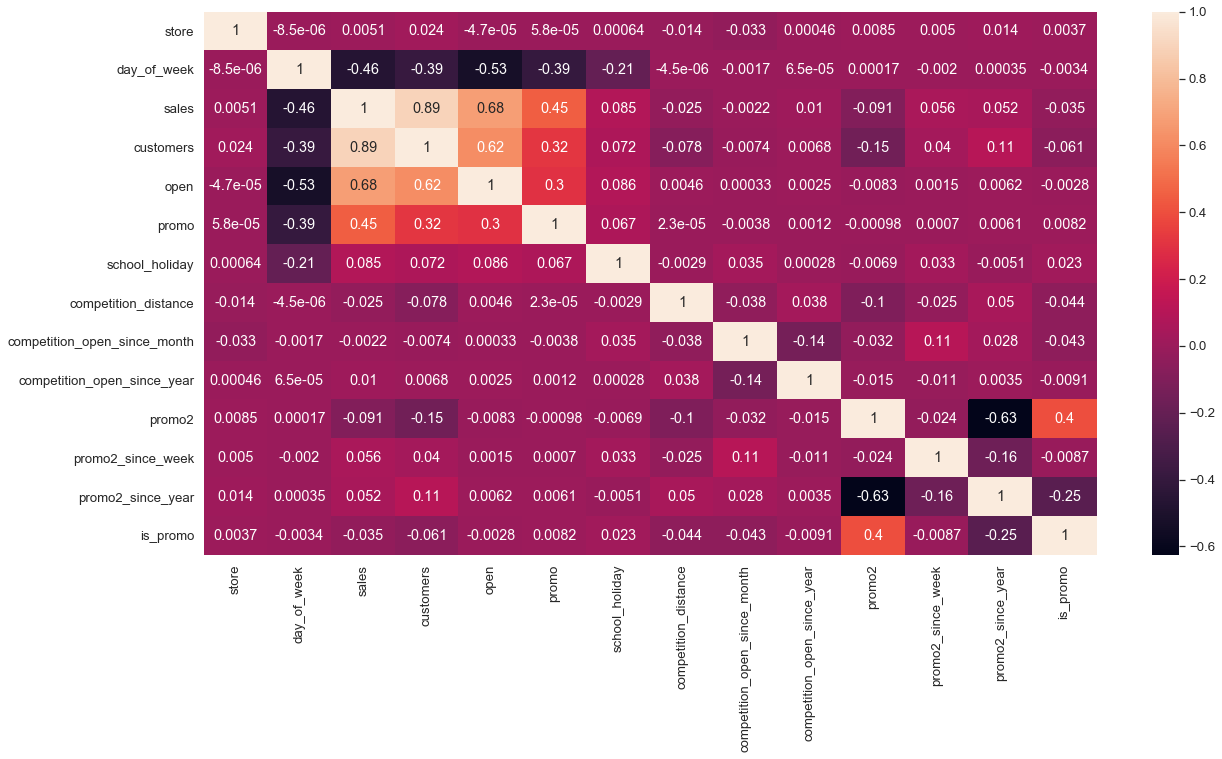

In [66]:
plt.figure(figsize=(20,10))
sns.heatmap(correlation, annot=True)

##### 4.3.1 CATEGOTICAL  ATTRIBUTES

In [67]:
a = df4.select_dtypes( include='object' )


In [68]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    chi2corr = max(0, (chi2 - (k-1)*(r-1)/(n-1)))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [69]:
cramer_v(a['state_holiday'], a['store_type'])

0.07106469715258833

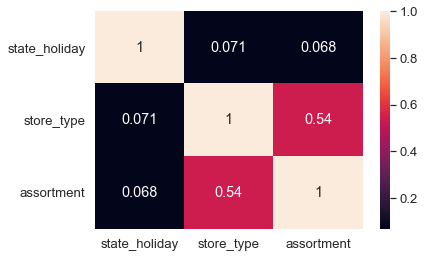

In [70]:
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

#setting categorical correlation matrix
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })

d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

### 5 - DATA PREPARATION

In [71]:
df5 = df4.copy()

#### 5.1 NORMALIZATION

Accordingly to the numerical univariate analysis, 4.1.1, there is no numerical feature with normal distribution. Thus, no normalization will be applied.


#### 5.2 RESCALING

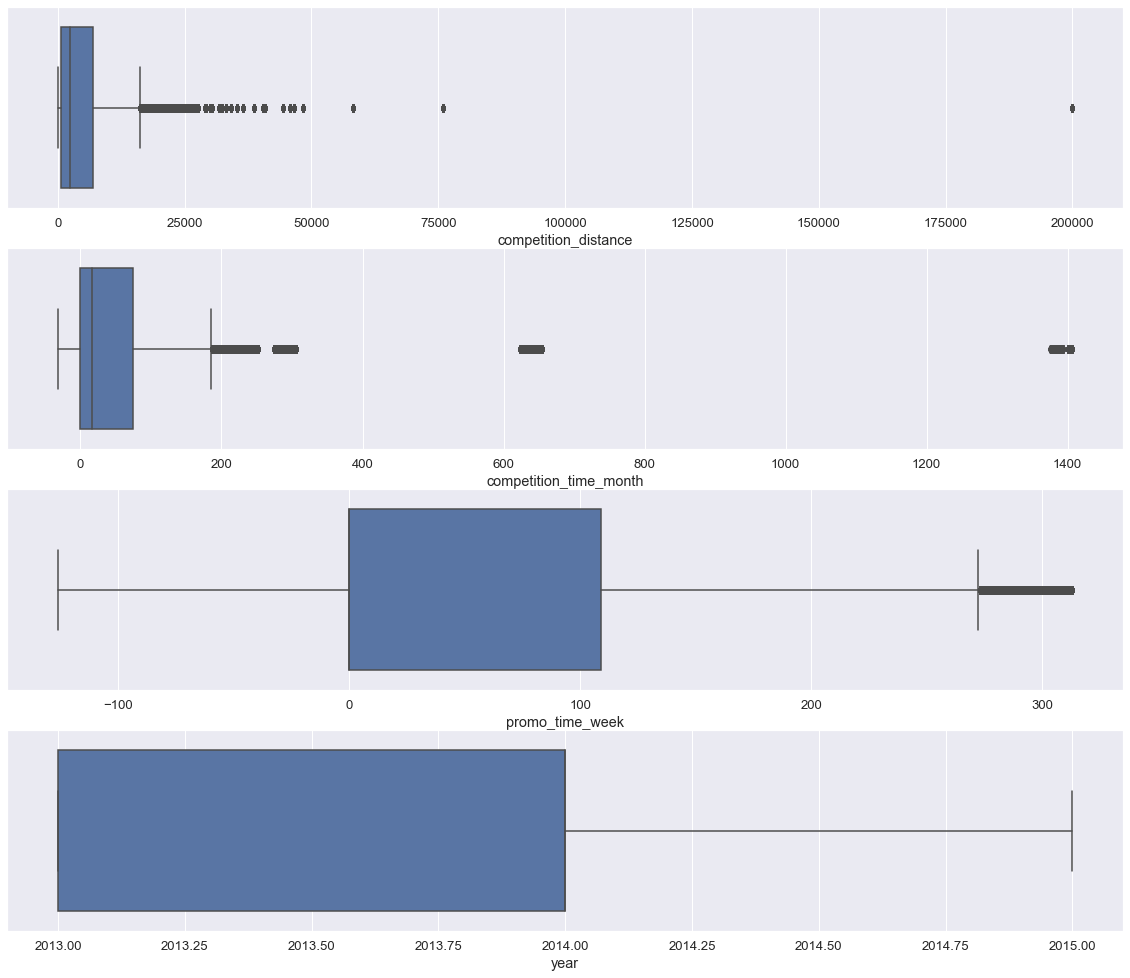

In [72]:
plt.subplots(figsize=(20, 17))
plt.subplot(4,1,1)
sns.boxplot(df5['competition_distance'])
plt.subplot(4,1,2)
sns.boxplot(df5['competition_time_month'])
plt.subplot(4,1,3)
sns.boxplot(df5['promo_time_week'])
plt.subplot(4,1,4)
sns.boxplot(df5['year'])

From the boxplot above we see that 'competition_distance' and 'competition_time_month' have distante outliers, thus Robust rescaling will be used.

Features 'promo_time_week' and 'year' don't show distante outliers, thus MinMaxScaler will be used to rescaling.


In [73]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

#### 5.3 TRANSFORMATION

##### 5.3.1 ENCODING

In [74]:
# state_holiday 
# since this feature indicates a diferent state of each tag, One Hot Encoding will be applied
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type 
# this feature is just naming the diferent stores, it don't point to diferent states and don't 
# show hierarchy, thus Label Encoding will be applied.
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment
# there is a hierarchal order in this feature, thus Ordinal Encoding will be applied
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

##### 5.3.2 RESPONSE VARIABLE TRANSFORMATION

In [75]:
df5['sales'] = np.log1p( df5['sales'] )

##### 5.3.3 NATURE TRANSFORMATION


In [76]:
#applying nature transformation to features that are cyclical

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

### 6 - FEATURE SELECTION

In [77]:
df6 = df5.copy()

#### 6.1 TRAIN TEST DF SPLIT

In [78]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 
             'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [79]:
#split here it's done having in mind that the dataset has a temporal feature, rows have  time when
#it was done. It's important to separate test and train sets in diferents sets of time. If you get 
#in train set rows of every slice of time it will result in data leakage. So for the test set, here
#will be separated the observations from the last 6 weeks.

# train dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

#### 6.2 BORUTA FEATURE SELECTOR

The two bellow cells are comented because boruta takes some time to run. 
As this was runned already, and results were obtained, they are comented to not run again when this notebook is started.

In [80]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

In [81]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [82]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# will hold this df version for the later time series cross validation, when date is needed
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

### 7 - MACHINE LEARNING MODELS

In [83]:
#functions to calculate errors

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

In [84]:
#getting only the selected features above
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

#### 7.1 BASELINE MODELS - DUMMY MODEL / MEAN MODEL

In [85]:
#model_dummy = DummyRegressor(strategy="mean").fit(x_train, y_train)
#
#yhat_dummy = model_dummy.predict( x_test )
#
#dummy_result = ml_error( 'Dummy model', np.expm1( y_test ), np.expm1( yhat_dummy ) )
#dummy_result

In [86]:
#aux1 = x_test.copy()
#aux1['sales'] = y_test.copy()
#
## prediction
#aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
#aux1 = pd.merge( aux1, aux2, how='left', on='store' )
#yhat_baseline = aux1['predictions']
#
## performance
#baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
#baseline_result

#### 7.2 LINEAR REGRESSION MODEL

In [87]:
# model
#lr = LinearRegression().fit( x_train, y_train )
#
## prediction
#yhat_lr = lr.predict( x_test )
#
## performance
#lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
#lr_result
#

#### 7.3 LINEAR REGRESSITION MODEL WITH LASSO REGULARIZATION 

In [88]:
# model
#lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )
#
## prediction
#yhat_lrr = lrr.predict( x_test )
#
## performance
#lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
#lrr_result

#### 7.4 RANDOM FOREST REGRESSOR 

In [89]:
# model
#rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )
#
## prediction
#yhat_rf = rf.predict( x_test )
#
## performance
#rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
#rf_result

#### 7.5 XGBOOST REGRESSOR

model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

prediction

In [90]:
## model
#model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                              n_estimators=100, 
#                              ).fit( x_train, y_train )
#
## prediction
#yhat_xgb = model_xgb.predict( x_test )
#
## performance
#xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
#xgb_result

#### 7.6 CROSS VALIDATION

In [91]:
#setting folds for time series cross validation
def cross_validation(x_training, kfold, model_name, model, verbose=False):

    mae_list = [] 
    mape_list = []
    rmse_list = [] 

    for k in reversed(range(1,kfold+1)):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7) #six weeks
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        #filtering df accordingly
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) &\
                                (x_training['date'] <= validation_end_date) ]

        #setting train and validation set
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        #model / prediction / performance
        m = model.fit(xtraining, ytraining)
        yhat = m.predict(xvalidation)
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( {'Model Name': model_name,
                              'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + \
                              np.round( np.std( mae_list ), 2 ).astype( str ),
                              'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + \
                              np.round( np.std( mape_list ), 2 ).astype( str ),
                              'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + \
                              np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

In [92]:
## Linear Regression Model - Cross Validation
#lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
#
## Lasso - Cross Validation
#lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
#
## Random Forest Regressor - Cross Validation
#rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
#
##XGBoost Regressor - Cross Validation
#xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )

#### 7.7 MODELS PERFORMANCE COMPARISON

##### 7.7.1 SINGLE PERFORMANCE

In [93]:
#modelling_result = pd.concat( [dummy_result, baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
#modelling_result.sort_values( 'RMSE' )

##### 7.7.2 CROSS VALIDATION PERFORMANCE - REAL GENERALIZATION

In [94]:
#modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
#modelling_result_cv

### 8 - MODEL PARAMETERS FINE TUNING 

#### 8.1 - RANDOM SEARCH

The code bellow is comented because it was already run, and the found parameters was stored.

This is due to avoid unecessary run time when revisiting this notebook.

In [95]:
# i used this values first to fine tune, than i funneled to values bellow and runed again.

# seeting range of parameters for the random search algorithm bellow
#parameters = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [96]:
# seeting range of parameters for the random search algorithm bellow
parameters = {
    'n_estimators': [2750, 3000, 3250],
    'eta': [0.25, 0.03, 0.35],
    'max_depth': [4, 5, 6],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.65, 0.7, 0.8],
    'min_child_weight': [2, 3, 4]
        }

MAX_EVAL = 5

In [97]:
## Random Search Fine tuning 
#
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in parameters.items() }
#    print( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#
#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
#        
#final_result

In [98]:
p1 = {'n_estimators': 2750, 'eta': 0.35, 'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.7, 'min_child_weight': 4}

p2 = {'n_estimators': 2750, 'eta': 0.35, 'max_depth': 6, 'subsample': 0.6, 'colsample_bytree': 0.7, 'min_child_weight': 2}

p3 = {'n_estimators': 2750, 'eta': 0.25, 'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 4}

p4 = {'n_estimators': 3250, 'eta': 0.35, 'max_depth': 6, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 2}

p5 = {'n_estimators': 3250, 'eta': 0.03, 'max_depth': 4, 'subsample': 0.6, 'colsample_bytree': 0.65, 'min_child_weight': 2}

                Model Name	    MAE CV	      MAPE CV	       RMSE CV

p1	XGBoost Regressor | 945.76 +/- 142.63 | 0.13 +/- 0.02 | 1349.13 +/- 201.64

p2	XGBoost Regressor | 982.91 +/- 136.15 | 0.14 +/- 0.01 | 1409.67 +/- 198.7
 
p3	XGBoost Regressor | 891.67 +/- 134.95 | 0.13 +/- 0.02 | 1280.89 +/- 193.42
 
p4	XGBoost Regressor | 951.85 +/- 157.35 | 0.14 +/- 0.02 | 1367.43 +/- 214.75
 
p5	XGBoost Regressor | 1037.99 +/- 121.23 | 0.15 +/- 0.01 | 1484.29 +/- 160.61



#### 8.2 FINAL TUNNED MODEL

In [99]:
##parameters P3 IS CHOSEN, as this parameters show lower error in the random search
#
#model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=2750, eta=0.25, max_depth=6,
#                             subsample=0.8, colsample_bytree=0.8, min_child_weight=4).fit(x_train, y_train)


In [100]:
##saving model
#model_xgb_saved = open('tunned_model_xgb.sav', 'wb')
#pickle.dump(model_xgb, model_xgb_saved)
#model_xgb_saved.close()

In [101]:
#loading trained tunned model

filename = 'tunned_model_xgb.sav'
model_xgb_tuned = pickle.load(open(filename, 'rb'))

In [102]:
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,686.793147,0.101974,987.281569


In [103]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
print( 'Mean Percentage Error: {}'.format( mpe ))

Mean Percentage Error: -0.015604709511127883


### 9 - ERROR INTERPRETATION / BUSINESS METRICS

In [105]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

C:\Users\jcbre\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\jcbre\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


#### Dúvidas

Dúvidas 

Módulo 05 - Video 02 : from numerical features types, why he choose only ['day_of_week', 'competition_distance', 'year', 'month', 'day', 'week_of_year', 'competition_time_month', 'promo_time_week] amongst lots of other numerical values.


Módulo 05 - Video 04 - RESPONSE VARIABLE TRANSFORMATION - this applied transformation transformed  a non-normal distribution to a normal distribution. This is important only for the response variable ?



Módulo 06 - Video 05 - Selecionando Variáveis com o Boruta - split it's done having in mind that the data set has a temporal feature, rows have the time when it was done. It's important to separate on test and train sets diferent sets of time, if you get in the train set rows of every splices of time it will result in data leakage (do NOT result in overfiting, like said in the video). So for the test set, here will be separated the observations from the last 6 weeks.

7.1 why the dummy regressor on means does not get same RMSE as the handed crafted one